# Unsupervised Hyperspectral Classification 
## KMeans, Principal Component Analysis

In this tutorial, we will use the `Spectral Python (SPy)` package to run KMeans and Principal Component Analysis unsupervised classification algorithms. 

http://www.spectralpython.net/user_guide.html
http://www.spectralpython.net/algorithms.html#unsupervised-classification

## Background

## KMeans - Clustering

http://www.spectralpython.net/algorithms.html#k-means-clustering

**KMeans** is an iterative clustering algorithm used to classify unsupervised data (eg. data without a training set) into a specified number of groups. The algorithm begins with an initial set of randomly determined cluster centers. Each pixel in the image is then assigned to the nearest cluster center (using distance in N-space as the distance metric) and each cluster center is then re-computed as the centroid of all pixels assigned to the cluster. This process repeats until a desired stopping criterion is reached (e.g. max number of iterations). 

To visualize how the algorithm works, it's easier look at a 2D data set. In the example below, watch how the cluster centers shift with progressive iterations, 

![gif](KMeans2D.gif)

https://sandipanweb.wordpress.com/2017/03/19/hard-soft-clustering-with-k-means-weighted-k-means-and-gmm-em/


## Principal Component Analysis (PCA) - Dimensionality Reduction

http://www.spectralpython.net/algorithms.html#principal-components

Many of the bands within hyperspectral images are often strongly correlated. The principal components transformation represents a linear transformation of the original image bands to a set of new, uncorrelated features. These new features correspond to the eigenvectors of the image covariance matrix, where the associated eigenvalue represents the variance in the direction of the eigenvector. A very large percentage of the image variance can be captured in a relatively small number of principal components (compared to the original number of bands) .


First, import the required packages and set display preferences:

In [1]:
from spectral import *
import spectral.io.envi as envi
import numpy as np
import matplotlib

For this example, we will read in a reflectance tile from the site SERC (Smithsonian Ecological Research Center) since this has a variety of landcover types (water, buildings, trees, etc.). This data is in the ENVI format (.hdr, .dat); NEON provides an h5 plugin for ENVI, since it is a popular software program for hyperspectral data visualization and analysis. You can also use the `aop_h5refl2array` function introduced in earlier tutorials, and use the `spectral` functions on the array, but some the geographic information is not automatically applied.

In [5]:
ls ../../data/D02_SERC

NEON_D02_SERC_DP3_368000_4306000_reflectance.dat
NEON_D02_SERC_DP3_368000_4306000_reflectance.hdr


In [6]:
img = envi.open('../../data/D02_SERC/NEON_D02_SERC_DP3_368000_4306000_reflectance.hdr',
                '../../data/D02_SERC/NEON_D02_SERC_DP3_368000_4306000_reflectance.dat')

Note that the information is stored differently when read in with `envi.open`, since we're now using a different Python package. We can find the wavelength information in `img.bands.centers`. Let's take a look at the first and last wavelengths values: 

In [7]:
print('First 3 Band Center Wavelengths:',img.bands.centers[:3])
print('Last 3 Band Center Wavelengths:',img.bands.centers[-3:])

First 3 Band Center Wavelengths: [383.534302, 388.542206, 393.55011]
Last 3 Band Center Wavelengths: [2501.878906, 2506.886719, 2511.894531]


We'll set the Water Vapor Band windows to `NaN` so we don't include them in the classification. 

In [8]:
img.bands.centers[191:211]==np.nan
img.bands.centers[281:314]==np.nan
img.bands.centers[-10:]==np.nan

False

To get a quick look at the `img` data, use the `params` method:

In [9]:
img.params

<bound method SpyFile.params of 	Data Source:   './../../data/D02_SERC/NEON_D02_SERC_DP3_368000_4306000_reflectance.dat'
	# Rows:           1000
	# Samples:        1000
	# Bands:           426
	Interleave:        BIP
	Quantization:  16 bits
	Data format:     int16>

Metadata information is stored in `img.metadata`, a dictionary. Let's look at the metadata contents:

In [10]:
md = img.metadata
print('Metadata Contents:')
for item in md:
    print('\t',item)

Metadata Contents:
	 description
	 samples
	 lines
	 bands
	 data type
	 interleave
	 file type
	 header offset
	 byte order
	 map info
	 coordinate system string
	 wavelength
	 fwhm
	 wavelength units
	 reflectance scale factor
	 data ignore value
	 dataset names


To access any of these metadata items, use the syntax eg. `md['description']` or `md['map info']`:

In [11]:
print('description:',md['description'])
print('map info:',md['map info'])

description: Atmospherically corrected reflectance.
map info: ['UTM', '1.000', '1.000', '368000.000', '4307000.000', '1.000000e+000', '1.000000e+000', '18', 'North', 'WGS-84', 'units=Meters']


You can also use `type` and `len` to look at the type and length (or number) of some of the metadata contents:

In [12]:
print(type(md['wavelength']))
print('Number of Bands:',len(md['wavelength']))

<class 'list'>
Number of Bands: 426


Let's look at the data using `imshow`, a wrapper around matplotlib's imshow for multi-band images:

ImageView object:
  Display bands       :  (58, 34, 19)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0058, 0.1471]
    G: [0.0184, 0.133]
    B: [0.0086, 0.1099]



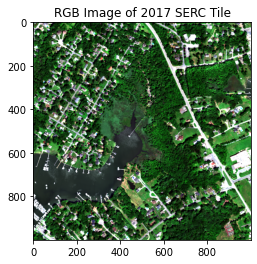

In [13]:
view = imshow(img,bands=(58,34,19),stretch=0.05,title="RGB Image of 2017 SERC Tile")
print(view)

When dealing with NEON hyperspectral data, we first want to remove the water vapor & noisy bands, keeping only the valid bands. To speed up the classification algorithms for demonstration purposes, we'll look at a subset of the data using `read_subimage`, a built in method in the `spectral` package to subset by area and bands. Type `help(img.read_subimage)` to see how it works. 

In [14]:
valid_band_range = [i for j in (range(0,191), range(212, 281), range(315,415)) for i in j] #remove water vapor bands
img_subset = img.read_subimage(range(400,600),range(400,600),bands=valid_band_range) #subset image by area and bands

Plot the subsetted image for reference:

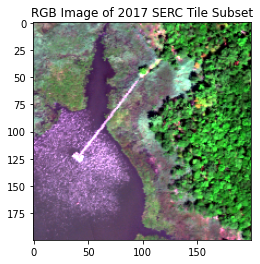

In [15]:
view = imshow(img_subset,bands=(58,34,19),stretch=0.01,title="RGB Image of 2017 SERC Tile Subset")

Now that we have the image subsetted, lets run the `k-means` algorithm. Type `help(kmeans)` to show how the function works. To run the k-means algorithm on the image and create 5 clusters, using a maximum of 50 iterations, use the following syntax:

In [16]:
(m,c) = kmeans(img_subset,5,50) 

spectral:INFO: k-means iteration 1 - 27267 pixels reassigned.
spectral:INFO: k-means iteration 2 - 3969 pixels reassigned.
spectral:INFO: k-means iteration 3 - 1690 pixels reassigned.
spectral:INFO: k-means iteration 4 - 1141 pixels reassigned.
spectral:INFO: k-means iteration 5 - 811 pixels reassigned.
spectral:INFO: k-means iteration 6 - 440 pixels reassigned.
spectral:INFO: k-means iteration 7 - 236 pixels reassigned.
spectral:INFO: k-means iteration 8 - 143 pixels reassigned.
spectral:INFO: k-means iteration 9 - 87 pixels reassigned.
spectral:INFO: k-means iteration 10 - 46 pixels reassigned.
spectral:INFO: k-means iteration 11 - 20 pixels reassigned.
spectral:INFO: k-means iteration 12 - 5 pixels reassigned.
spectral:INFO: k-means iteration 13 - 2 pixels reassigned.
spectral:INFO: k-means iteration 14 - 1 pixels reassigned.
spectral:INFO: k-means iteration 15 - 0 pixels reassigned.
spectral:INFO: kmeans terminated with 5 clusters after 14 iterations.


Note that the algorithm terminated afte 14 iterations, when the pixels stopped being reassigned. 

**Data Tip**: You can iterrupt the algorithm with a keyboard interrupt (CTRL-C) if you notice that the number of reassigned pixels drops off. Kmeans catches the KeyboardInterrupt exception and returns the clusters generated at the end of the previous iteration. If you are running the algorithm interactively, this feature allows you to set the max number of iterations to an arbitrarily high number and then stop the algorithm when the clusters have converged to an acceptable level. If you happen to set the max number of iterations too small (many pixels are still migrating at the end of the final iteration), you can simply call kmeans again to resume processing by passing the cluster centers generated by the previous call as the optional `start_clusters` argument to the function.

Let's take a look at the cluster centers `c`. In this case, these represent spectras of the five clusters of reflectance that the data were grouped into.

In [17]:
print(c.shape)

(5, 360)


`c` contains 5 groups of spectral curves with 360 bands (the # of bands we've kept after removing the water vapor windows and the last 10 noisy bands). Let's plot these spectral classes:

Text(0, 0.5, 'Reflectance')

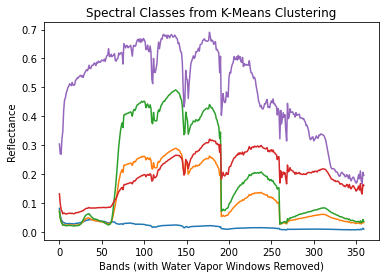

In [19]:
%matplotlib inline
import pylab
pylab.figure()
for i in range(c.shape[0]):
    pylab.plot(c[i])
pylab.show
pylab.title('Spectral Classes from K-Means Clustering')
pylab.xlabel('Bands (with Water Vapor Windows Removed)')
pylab.ylabel('Reflectance')

<bound method ImageView.show_data of ImageView object:
  Display bands       :  (58, 34, 19)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0055, 0.0617]
    G: [0.0184, 0.0893]
    B: [0.0083, 0.0503]
>

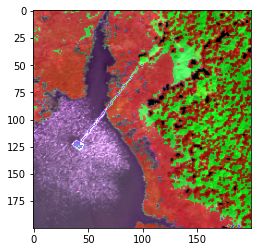

In [20]:
#%matplotlib notebook
view = imshow(img_subset, bands=(58,34,19),stretch=0.01, classes=m)
view.set_display_mode('overlay')
view.class_alpha = 0.5 #set transparency
view.show_data

## On your own:

- Try using a different number of clusters in the `kmeans` algorithm (eg. 3, 10) to see what spectral classes and classifications result. 

## Principal Component Analysis (PCA)

Many of the bands within hyperspectral images are often strongly correlated. The principal components transformation represents a linear transformation of the original image bands to a set of new, uncorrelated features. These new features correspond to the eigenvectors of the image covariance matrix, where the associated eigenvalue represents the variance in the direction of the eigenvector. A very large percentage of the image variance can be captured in a relatively small number of principal components (compared to the original number of bands) .

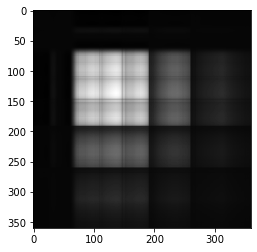

In [21]:
pc = principal_components(img_subset)
pc_view = imshow(pc.cov)
xdata = pc.transform(img_subset)

In the covariance matrix display, lighter values indicate strong positive covariance, darker values indicate strong negative covariance, and grey values indicate covariance near zero.

In [22]:
pcdata = pc.reduce(num=10).transform(img_subset)

5
(200, 200, 5)


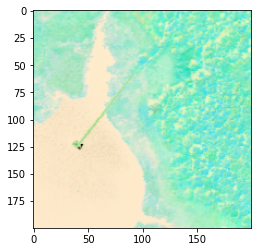

In [23]:
pc_0999 = pc.reduce(fraction=0.999)

# How many eigenvalues are left?
print(len(pc_0999.eigenvalues))

img_pc = pc_0999.transform(img_subset)
print(img_pc.shape)

v = imshow(img_pc[:,:,:5], stretch_all=True)

## References

Dey, Sandipan (2017). Hard & Soft Clustering with K-means, Weighted K-means and GMM-EM in Python. 
https://sandipanweb.wordpress.com/2017/03/19/hard-soft-clustering-with-k-means-weighted-k-means-and-gmm-em/